In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


## **EDA**

In [3]:
data = pd.read_csv("retail_store_inventory.csv")

# Converting the Date column to "datetime objects", and making it the index of the df.
## For the time-series viz a few lines down.
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek  # Monday=0, Sunday=6

# Calculating the price difference between "our" product and competitors
data['Price_Difference'] = data['Price'] - data['Competitor Pricing']

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            73100 non-null  object 
 1   Product ID          73100 non-null  object 
 2   Category            73100 non-null  object 
 3   Region              73100 non-null  object 
 4   Inventory Level     73100 non-null  int64  
 5   Units Sold          73100 non-null  int64  
 6   Units Ordered       73100 non-null  int64  
 7   Demand Forecast     73100 non-null  float64
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
 14  Year                73100 non-null  int32  
 15  Month               73100 non-null  

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Year,Month,Day,DayOfWeek,Price_Difference
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077,2022.502052,6.518468,15.700410,3.002736,-0.010969
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408,0.502728,3.451564,8.807111,2.003429,2.888538
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000,2022.000000,1.000000,1.000000,0.000000,-5.000000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000,2022.000000,4.000000,8.000000,1.000000,-2.530000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000,2023.000000,7.000000,16.000000,3.000000,0.000000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000,2023.000000,10.000000,23.000000,5.000000,2.500000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000,2024.000000,12.000000,31.000000,6.000000,5.000000


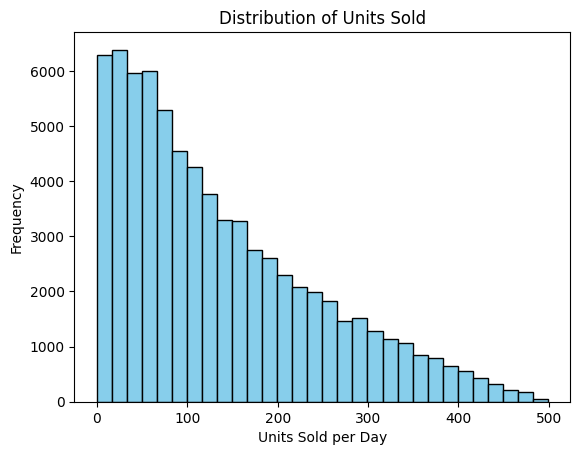

In [6]:
plt.hist(data['Units Sold'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Units Sold per Day')
plt.ylabel('Frequency')
plt.title('Distribution of Units Sold')

plt.show()

<Axes: >

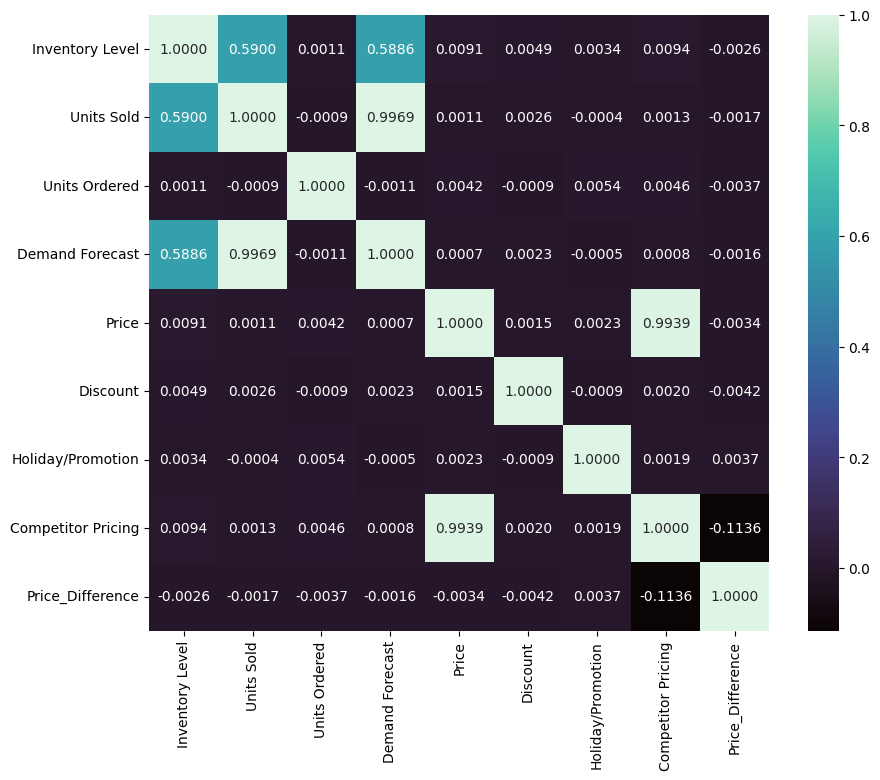

In [293]:
numerical_features = data.select_dtypes(include=["Int64","float64"]).columns

correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="mako", fmt=".4f")

**Weeky Trends**

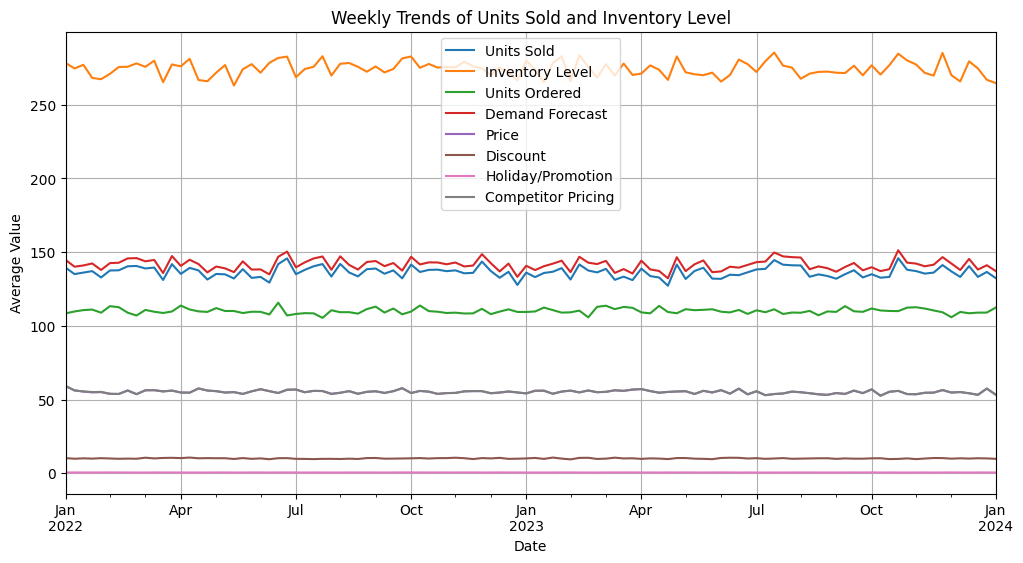

In [294]:
plt.figure(figsize=(12, 6))


data.resample('W')['Units Sold'].mean().plot()
data.resample('W')['Inventory Level'].mean().plot()
data.resample('W')['Units Ordered'].mean().plot()
data.resample('W')['Demand Forecast'].mean().plot()
data.resample('W')['Price'].mean().plot()
data.resample('W')['Discount'].mean().plot()
data.resample('W')['Holiday/Promotion'].mean().plot()
data.resample('W')['Competitor Pricing'].mean().plot()

plt.title('Weekly Trends of Units Sold and Inventory Level')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

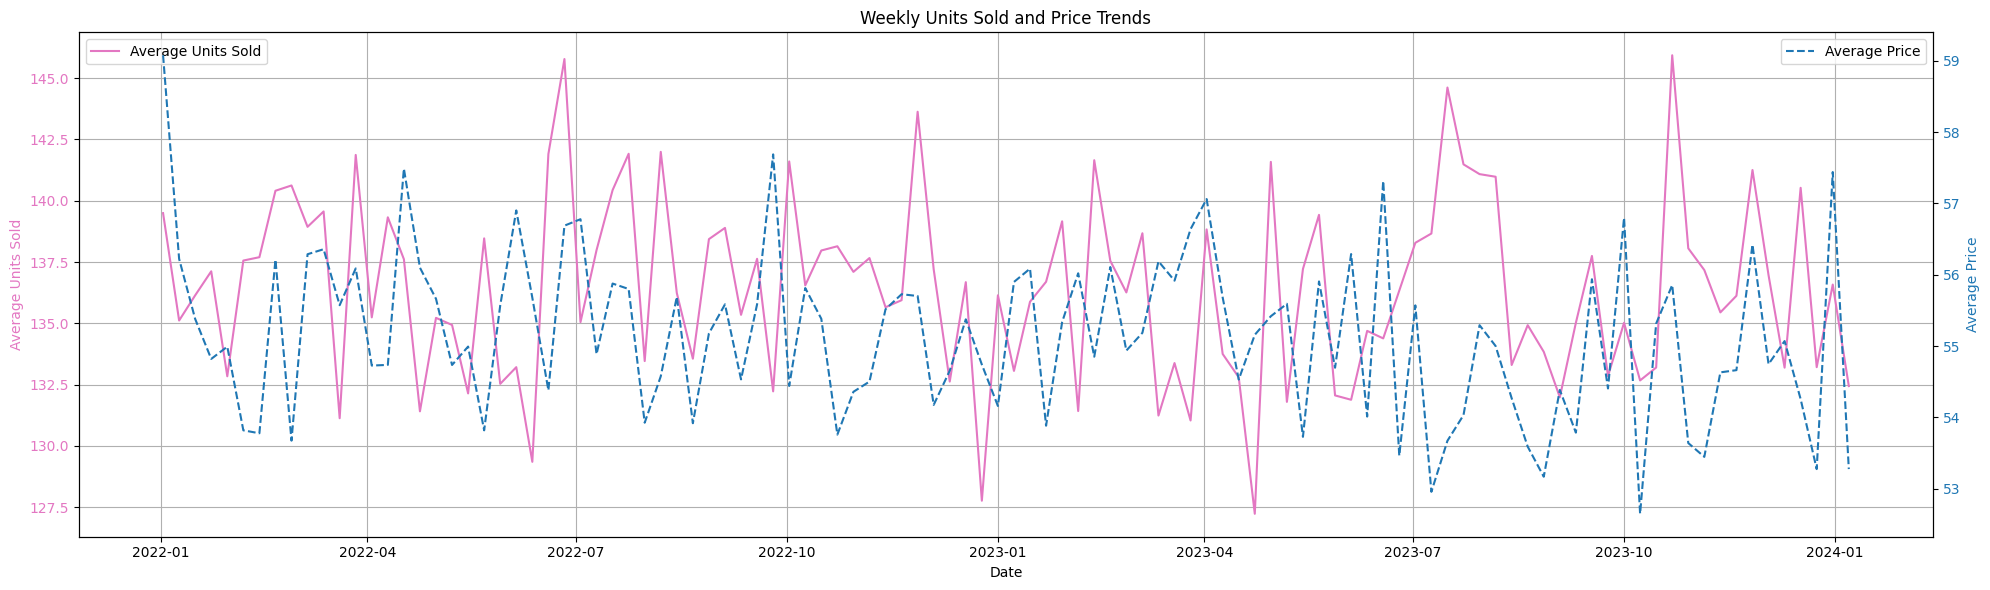

In [295]:
weekly_units_sold = data.resample('W')['Units Sold'].mean()
weekly_price = data.resample('W')['Price'].mean()

fig, ax1 = plt.subplots(figsize=(20, 6))

color_units = 'tab:pink'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Units Sold', color=color_units)
ax1.plot(weekly_units_sold.index, weekly_units_sold.values, color=color_units, label='Average Units Sold')
ax1.tick_params(axis='y', labelcolor=color_units)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
color_price = 'tab:blue'
ax2.set_ylabel('Average Price', color=color_price)
ax2.plot(weekly_price.index, weekly_price.values, color=color_price, linestyle='--', label='Average Price')
ax2.tick_params(axis='y', labelcolor=color_price)
ax2.legend(loc='upper right')

plt.title('Weekly Units Sold and Price Trends')
fig.tight_layout()
plt.show()

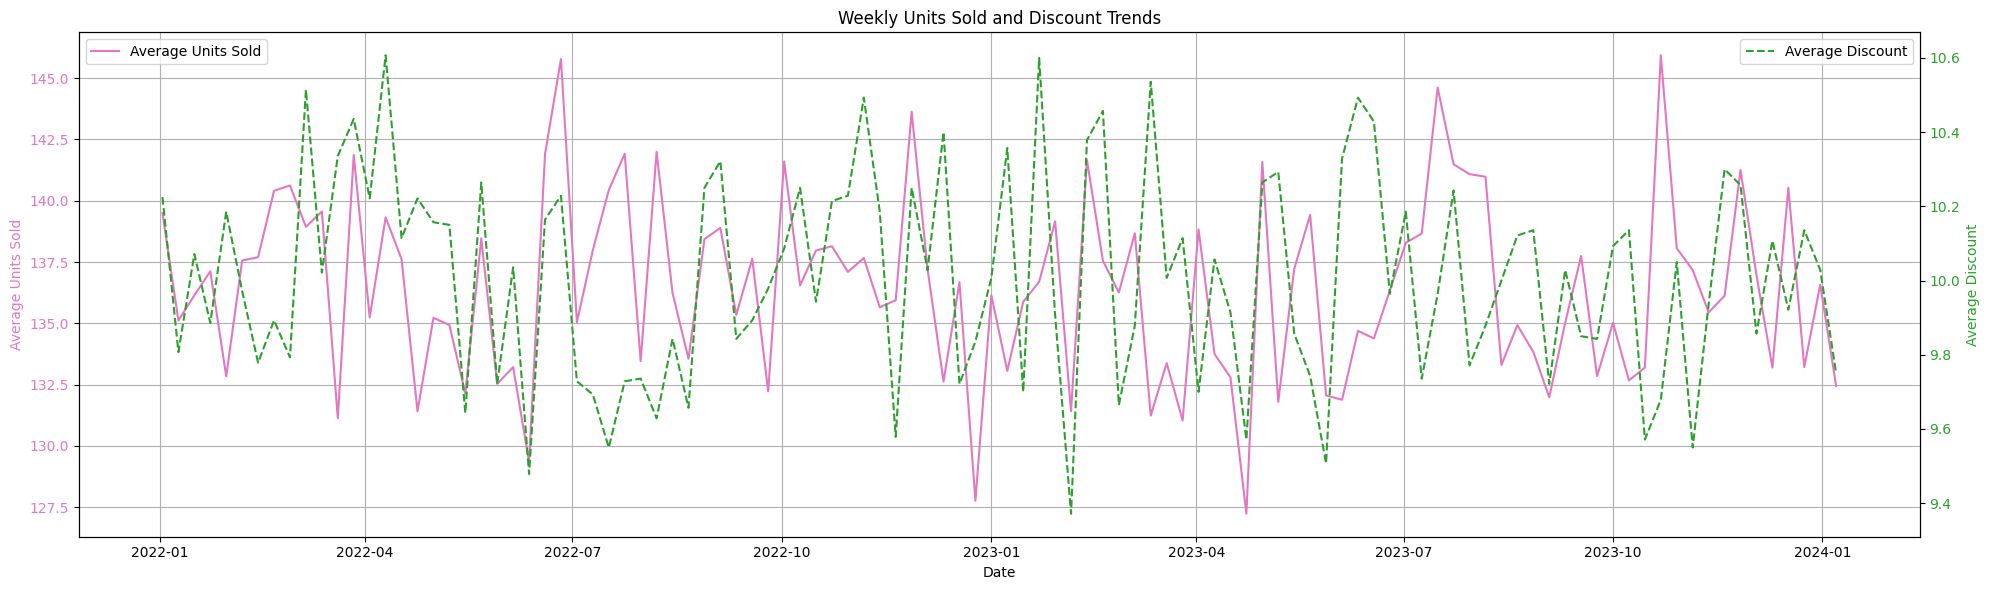

In [296]:
weekly_units_sold = data.resample('W')['Units Sold'].mean()
weekly_discount = data.resample('W')['Discount'].mean()

fig, ax1 = plt.subplots(figsize=(20, 6))

color_units = 'tab:pink'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Units Sold', color=color_units)
ax1.plot(weekly_units_sold.index, weekly_units_sold.values, color=color_units, label='Average Units Sold')
ax1.tick_params(axis='y', labelcolor=color_units)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
color_discount = 'tab:green'
ax2.set_ylabel('Average Discount', color=color_discount)
ax2.plot(weekly_discount.index, weekly_discount.values, color=color_discount, linestyle='--', label='Average Discount')
ax2.tick_params(axis='y', labelcolor=color_discount)
ax2.legend(loc='upper right')

plt.title('Weekly Units Sold and Discount Trends')
fig.tight_layout()
plt.show()

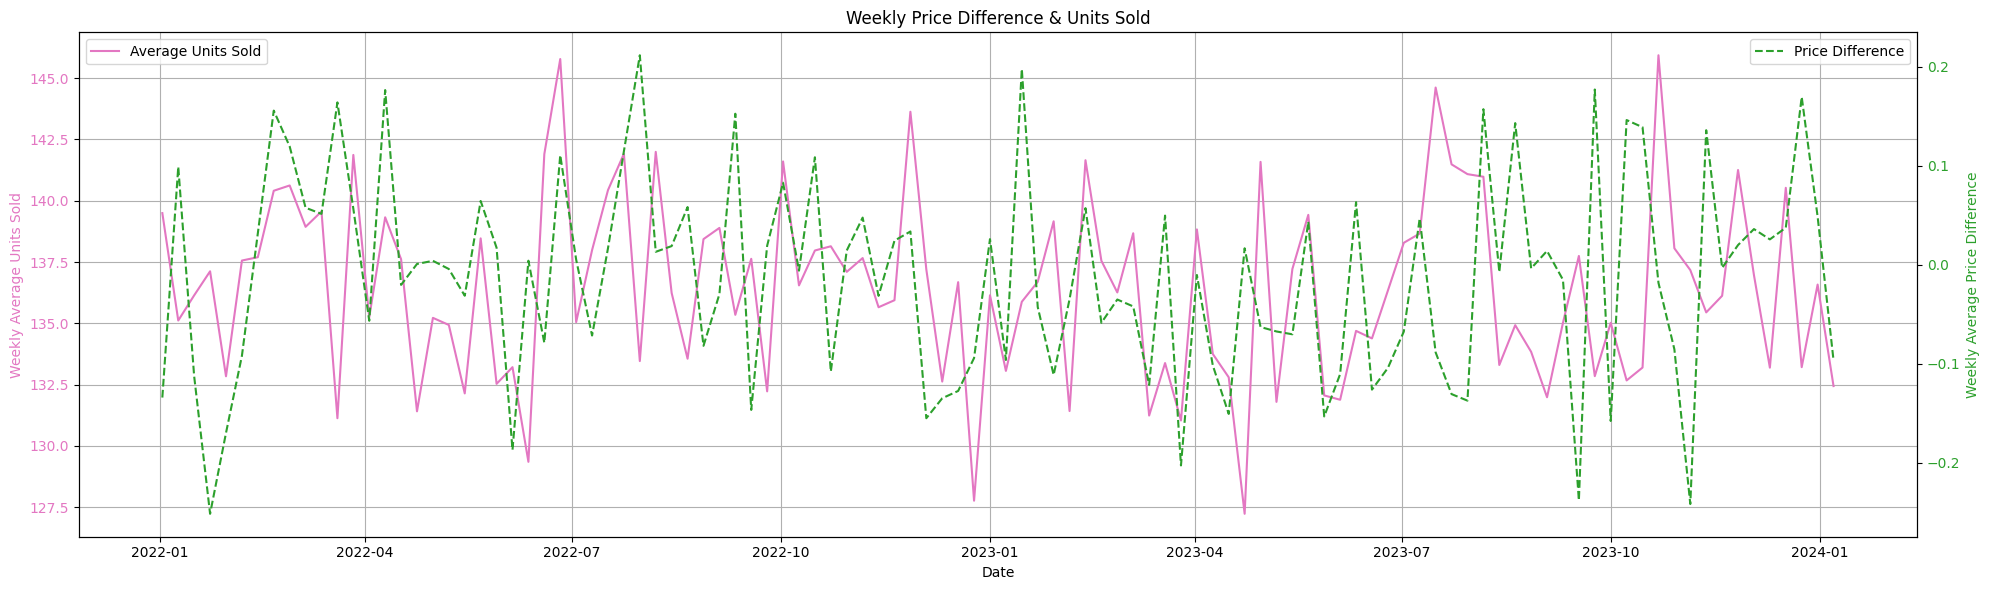

In [297]:
weekly_units_sold = data.resample('W')['Units Sold'].mean()
weekly_diff = data.resample('W')['Price_Difference'].mean()

fig, ax1 = plt.subplots(figsize=(20, 6))

color = 'tab:pink'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Average Units Sold', color=color)
ax1.plot(weekly_units_sold.index, weekly_units_sold.values, color=color, label='Average Units Sold')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Weekly Average Price Difference', color=color)
ax2.plot(weekly_diff.index, weekly_diff, color=color, linestyle='--', label='Price Difference')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title("Weekly Price Difference & Units Sold")
fig.tight_layout()
plt.show()

Can clearly see theres an inverse relationship with price difference and units sold... when "our" price is lower, we sell more units.

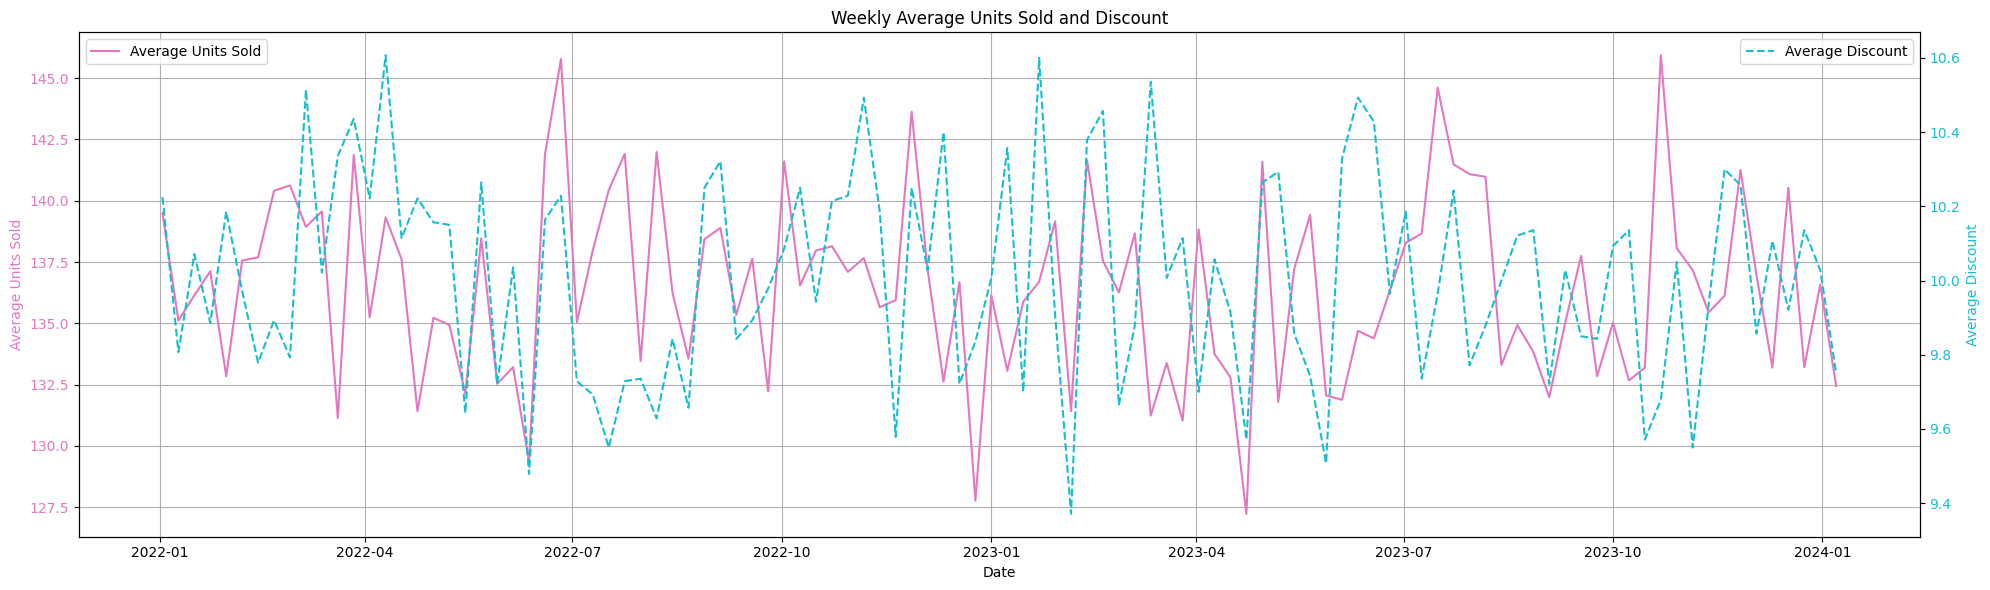

In [298]:
weekly_units_sold = data.resample('W')['Units Sold'].mean()
weekly_discount = data.resample('W')['Discount'].mean()

fig, ax1 = plt.subplots(figsize=(20, 6))

color_units = 'tab:pink'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Units Sold', color=color_units)
ax1.plot(weekly_units_sold.index, weekly_units_sold.values, color=color_units, label='Average Units Sold')
ax1.tick_params(axis='y', labelcolor=color_units)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
color_discount = 'tab:cyan'
ax2.set_ylabel('Average Discount', color=color_discount)
ax2.plot(weekly_discount.index, weekly_discount.values, color=color_discount, linestyle='--', label='Average Discount')
ax2.tick_params(axis='y', labelcolor=color_discount)
ax2.legend(loc='upper right')

plt.title('Weekly Average Units Sold and Discount')
fig.tight_layout()
plt.show()

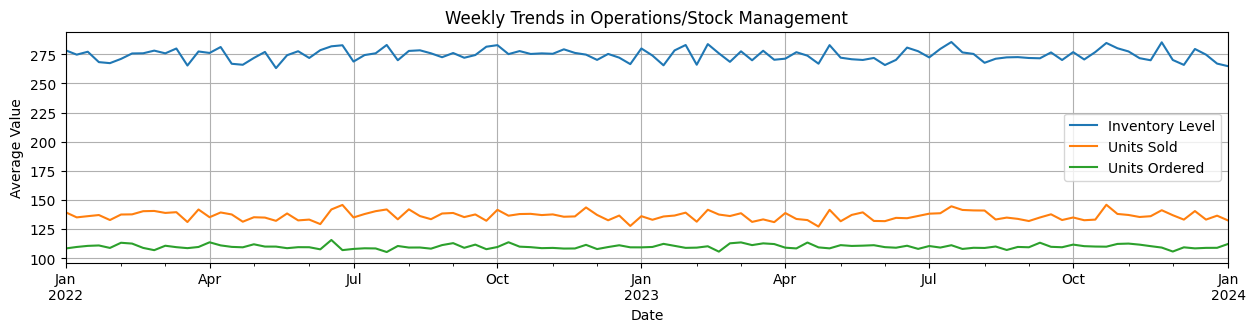

In [299]:
plt.figure(figsize=(15, 3))

data.resample('W')['Inventory Level'].mean().plot()
data.resample('W')['Units Sold'].mean().plot()
data.resample('W')['Units Ordered'].mean().plot()

plt.title('Weekly Trends in Operations/Stock Management')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

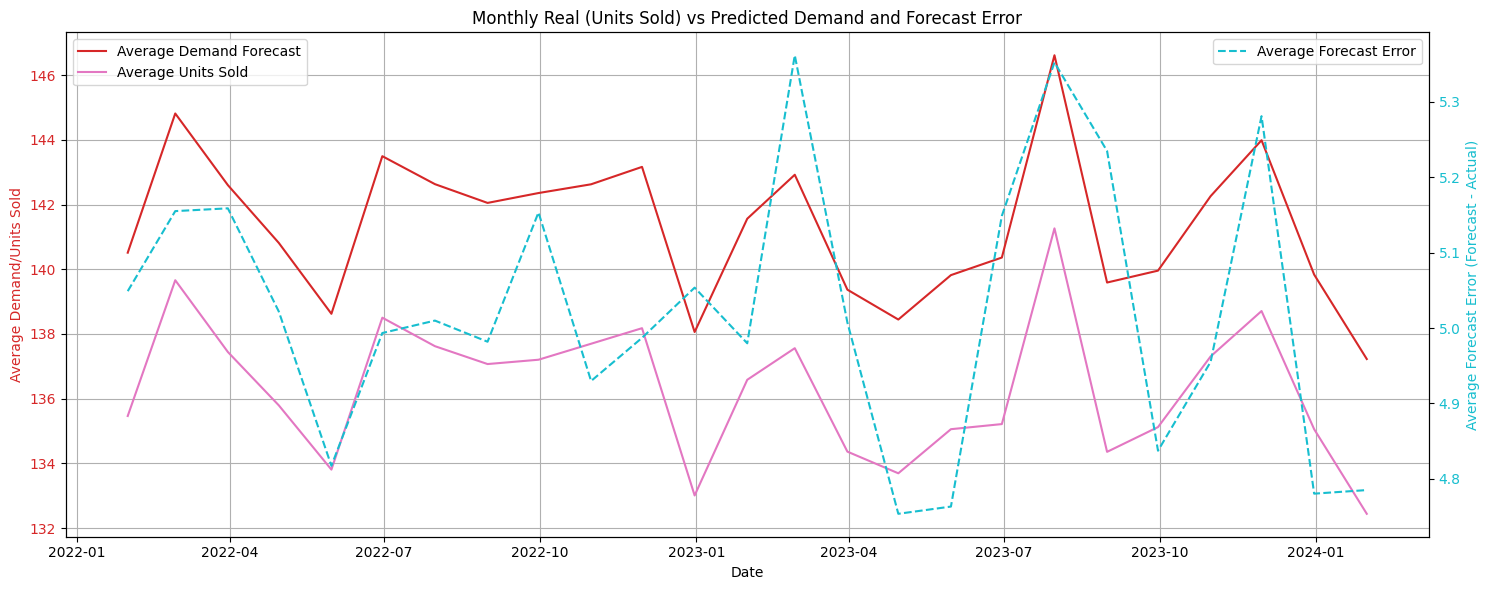

In [300]:
monthly_demand_forecast = data.resample('ME')['Demand Forecast'].mean()
monthly_units_sold = data.resample('ME')['Units Sold'].mean()

# Calculating the forecast error
monthly_forecast_error = monthly_demand_forecast - monthly_units_sold

fig, ax1 = plt.subplots(figsize=(15, 6))

color_demand = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Demand/Units Sold', color=color_demand)
ax1.plot(monthly_demand_forecast.index, monthly_demand_forecast.values, color=color_demand, label='Average Demand Forecast')
ax1.plot(monthly_units_sold.index, monthly_units_sold.values, color='tab:pink', label='Average Units Sold')
ax1.tick_params(axis='y', labelcolor=color_demand)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
color_error = 'tab:cyan'
ax2.set_ylabel('Average Forecast Error (Forecast - Actual)', color=color_error)
ax2.plot(monthly_forecast_error.index, monthly_forecast_error.values, color=color_error, linestyle='--', label='Average Forecast Error')
ax2.tick_params(axis='y', labelcolor=color_error)
ax2.legend(loc='upper right')

plt.title('Monthly Real (Units Sold) vs Predicted Demand and Forecast Error')
fig.tight_layout()
plt.show()

Categorical breakdown of Sales

<Axes: xlabel='Category', ylabel='Units Sold'>

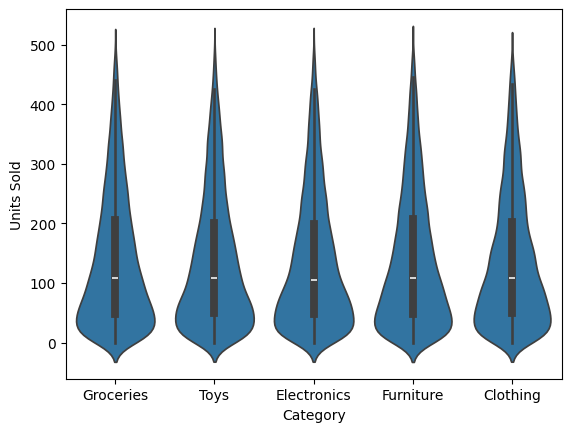

In [301]:
sns.violinplot(x='Category', y='Units Sold', data=data)

Regional breakdown of Sales

<Axes: xlabel='Region', ylabel='Units Sold'>

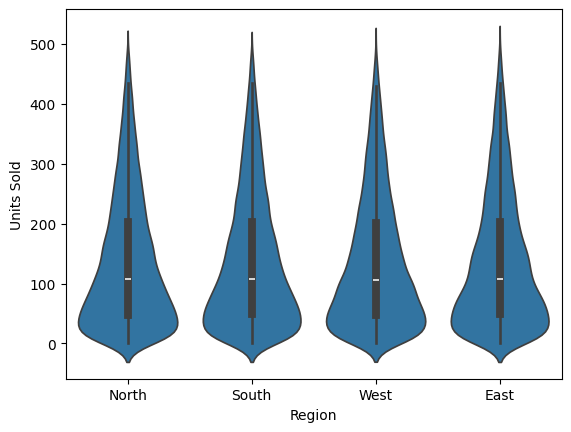

In [302]:
sns.violinplot(x='Region', y='Units Sold', data=data)

## **Data Preprocessing & Feature Engineering**

In [303]:
# Feature Engineering - Some pretty important metrics in Supply Chain
    ## Need to be careful with these, to prevent data leakage... be mindful of 
    ## what the target variable is, make sure to not use any engineered features
    ## that are derived from it...


data['Price_Discount_Ratio'] = data['Price'] / (data['Discount'] + 1)
# Captures price sensitivity and promotion impact.

data['Stock_to_Sales_Ratio'] = data['Inventory Level'] / data['Units Sold'].replace(0, np.nan)
# Indicates how much inventory is held, relative to sales. Indicates overstock or understock situations.

data['Sell_thru_Rate'] = data['Units Sold'] / (data['Units Sold'] + data['Inventory Level'])
# Percentage of inventory sold to customers

data['Backorder_Rate'] = (data['Units Ordered'] - data['Units Sold']) / data['Units Ordered'].replace(0, np.nan)
# Proportion of orders not fulfilled immediately. A sign of demand exceeding supply.

data['Order_Fulfillment_Rate'] = data['Units Sold'] / data['Units Ordered'].replace(0, np.nan)
# Inverse of Backorder Rate. How well you are meeting customer demand. 

data['Competitor_Price_Ratio'] = data['Price'] / data['Competitor Pricing'].replace(0, np.nan)
# Measures price positioning vs. competitors.

data['Demand_Forecast_Error'] = data['Units Sold'] - data['Demand Forecast']
# Difference between predicted and actual Demand.

In [304]:
# The Lagged features need to be properly sorted first before creating.
data = data.sort_values(by=['Product ID', 'Store ID', 'Year', 'Month', 'Day'])

data['Previous_Day_Units_Sold'] = data.groupby(['Product ID', 'Store ID'])['Units Sold'].shift(1)
# Lagged (by 1 day) Units Sold. "Yesterday's Sales". 

data['7Day_RollingAvg_Units_Sold'] = data.groupby(['Product ID', 'Store ID'])['Units Sold'].rolling(window=7, min_periods=1).mean().reset_index(level=[0,1], drop=True)
# 7-day rolling mean of Units Sold

data['7Day_RollingAvg_Inventory'] = data.groupby(['Product ID', 'Store ID'])['Inventory Level'].rolling(window=7, min_periods=1).mean().reset_index(level=[0, 1], drop=True)
# 7-day rolling average of Inventory Level

data['Inventory_Turnover_Rate'] = data['Units Sold'] / (data['7Day_RollingAvg_Inventory'] + 1e-6)
# A more stable Inventory Turnover rate, using the rolling average inventory...

In [305]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Store ID                    73100 non-null  object 
 1   Product ID                  73100 non-null  object 
 2   Category                    73100 non-null  object 
 3   Region                      73100 non-null  object 
 4   Inventory Level             73100 non-null  int64  
 5   Units Sold                  73100 non-null  int64  
 6   Units Ordered               73100 non-null  int64  
 7   Demand Forecast             73100 non-null  float64
 8   Price                       73100 non-null  float64
 9   Discount                    73100 non-null  int64  
 10  Weather Condition           73100 non-null  object 
 11  Holiday/Promotion           73100 non-null  int64  
 12  Competitor Pricing          73100 non-null  float64
 13  Seasonality   

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,...,Stock_to_Sales_Ratio,Sell_thru_Rate,Backorder_Rate,Order_Fulfillment_Rate,Competitor_Price_Ratio,Demand_Forecast_Error,Previous_Day_Units_Sold,7Day_RollingAvg_Units_Sold,7Day_RollingAvg_Inventory,Inventory_Turnover_Rate
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,...,1.818898,0.354749,-1.309091,2.309091,1.128326,-8.47,NaN,127.000000,231.000000,0.549784
2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,...,1.432099,0.411168,0.221154,0.778846,0.904824,-11.94,127.0,104.000000,173.500000,0.466859
2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,...,30.800000,0.031447,0.973545,0.026455,1.076950,-0.36,81.0,71.000000,167.000000,0.029940
2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,...,1.465517,0.405594,0.699482,0.300518,1.024872,5.13,5.0,67.750000,146.500000,0.395904
2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,...,1.619048,0.381818,-2.972973,3.972973,0.968027,-3.27,58.0,83.600000,164.800000,0.891990
2022-01-06,S001,P0001,Electronics,East,198,37,155,39.09,91.05,5,...,5.351351,0.157447,0.761290,0.238710,1.042955,-2.09,147.0,75.833333,170.333333,0.217221
2022-01-07,S001,P0001,Furniture,North,195,107,106,117.92,53.99,10,...,1.822430,0.354305,-0.009434,1.009434,0.918197,-10.92,37.0,80.285714,173.857143,0.615448
2022-01-08,S001,P0001,Furniture,East,231,2,119,0.84,66.30,20,...,115.500000,0.008584,0.983193,0.016807,1.038859,1.16,107.0,62.428571,173.857143,0.011504
2022-01-09,S001,P0001,Electronics,South,373,350,178,352.24,41.72,0,...,1.065714,0.484094,-0.966292,1.966292,1.078594,-2.24,2.0,100.857143,210.571429,1.662144


In [306]:
# Dropping Rows with NaN in any of the Rolling Feature Columns
# dropna() with the 'subset' argument, makes sure we are ONLY 
# dropping rows that were in the initial rows for each group. 

columns_to_check = ['Previous_Day_Units_Sold', 
                    '7Day_RollingAvg_Units_Sold', 
                    '7Day_RollingAvg_Inventory', 
                    'Inventory_Turnover_Rate']

data.dropna(subset=columns_to_check, inplace=True)

print(f"Number of rows after dropping NaNs: {len(data)}")
data.head(10)

Number of rows after dropping NaNs: 73000


,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,...,Stock_to_Sales_Ratio,Sell_thru_Rate,Backorder_Rate,Order_Fulfillment_Rate,Competitor_Price_Ratio,Demand_Forecast_Error,Previous_Day_Units_Sold,7Day_RollingAvg_Units_Sold,7Day_RollingAvg_Inventory,Inventory_Turnover_Rate
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,...,1.432099,0.411168,0.221154,0.778846,0.904824,-11.94,127.0,104.000000,173.500000,0.466859
2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,...,30.800000,0.031447,0.973545,0.026455,1.076950,-0.36,81.0,71.000000,167.000000,0.029940
2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,...,1.465517,0.405594,0.699482,0.300518,1.024872,5.13,5.0,67.750000,146.500000,0.395904
2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,...,1.619048,0.381818,-2.972973,3.972973,0.968027,-3.27,58.0,83.600000,164.800000,0.891990
2022-01-06,S001,P0001,Electronics,East,198,37,155,39.09,91.05,5,...,5.351351,0.157447,0.761290,0.238710,1.042955,-2.09,147.0,75.833333,170.333333,0.217221
2022-01-07,S001,P0001,Furniture,North,195,107,106,117.92,53.99,10,...,1.822430,0.354305,-0.009434,1.009434,0.918197,-10.92,37.0,80.285714,173.857143,0.615448
2022-01-08,S001,P0001,Furniture,East,231,2,119,0.84,66.30,20,...,115.500000,0.008584,0.983193,0.016807,1.038859,1.16,107.0,62.428571,173.857143,0.011504
2022-01-09,S001,P0001,Electronics,South,373,350,178,352.24,41.72,0,...,1.065714,0.484094,-0.966292,1.966292,1.078594,-2.24,2.0,100.857143,210.571429,1.662144
2022-01-10,S001,P0001,Electronics,West,327,36,132,39.50,32.68,5,...,9.083333,0.099174,0.727273,0.272727,0.941515,-3.50,350.0,105.285714,235.285714,0.153005


Creating a Customizable Pipleline and Regression Template, I can reuse throught this project for all the different models I'll try to make. Will help me decide if I should move forward with a random forest, or just keep it simple with singular Linear Regression.

In [307]:
'''

### Pipeline

# Categorical features (Remove the Target (y) from this each time, so we don't scale it)
categorical_features = [
    'Store ID', 'Product ID', 'Weather Condition', 'Holiday/Promotion',
    'Category', 'Region', 'Seasonality', 'Year', 'Month', 'Day', 'DayOfWeek'
]

# Numerical features (Remove the Target (y) from this each time, so we don't scale it)
numerical_features = [
    'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
    'Price', 'Discount', 'Competitor Pricing', 'Price_Discount_Ratio', 
    'Stock_to_Sales_Ratio', 'Sell_thru_Rate', 'Backorder_Rate', 'Order_Fulfillment_Rate',
    'Competitor_Price_Ratio', 'Previous_Day_Units_Sold', '7Day_RollingAvg_Units_Sold',
    'Demand_Forecast_Error', '7Day_RollingAvg_Inventory', 'Inventory_Turnover_Rate'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # For the Lagging Features, that always have 1 NaN in the first entry.
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) 
    ],
    remainder='drop'
)


### Regression(s)

# Specify Target (y) feature here, and the specific Feature's to try predicting with,
# and make sure to go back up and remove the (y) from the preprocessing pipeline!!!

X = data['Price', 'Discount', 'Price_Discount_Ratio', 'Weather Condition', 
         'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']

y = data['Units Sold']  # <-- Target for this Regression is "Units Sold"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Reusable/Versatile pipeline template
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

models = {
        'Linear Regression': LinearRegression(),
        'Lasso': LassoCV(cv=5, max_iter=1000),
        'Ridge': RidgeCV(alphas=[0.1, 1, 10]),
        'Decision Tree': DecisionTreeRegressor(max_depth=5),
        'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    }

results = {}
for name, model in models.items():
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[name] = {
        'MSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R^2': r2_score(y_test, y_pred)
    }

pd.DataFrame(results).T

'''

'\n\n### Pipeline\n\n# Categorical features (Remove the Target (y) from this each time, so we don\'t scale it)\ncategorical_features = [\n    \'Store ID\', \'Product ID\', \'Weather Condition\', \'Holiday/Promotion\',\n    \'Category\', \'Region\', \'Seasonality\', \'Year\', \'Month\', \'Day\', \'DayOfWeek\'\n]\n\n# Numerical features (Remove the Target (y) from this each time, so we don\'t scale it)\nnumerical_features = [\n    \'Inventory Level\', \'Units Sold\', \'Units Ordered\', \'Demand Forecast\',\n    \'Price\', \'Discount\', \'Competitor Pricing\', \'Price_Discount_Ratio\', \n    \'Stock_to_Sales_Ratio\', \'Sell_thru_Rate\', \'Backorder_Rate\', \'Order_Fulfillment_Rate\',\n    \'Competitor_Price_Ratio\', \'Previous_Day_Units_Sold\', \'7Day_RollingAvg_Units_Sold\',\n    \'Demand_Forecast_Error\', \'7Day_RollingAvg_Inventory\', \'Inventory_Turnover_Rate\'\n]\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        (\'num\', Pipeline([\n            (\'imputer\', SimpleIm

## **Model 1) Sales Volume (REAL Demand) Prediction**

**Target Variable**: Units Sold

In [308]:
### Pipeline

# Categorical features (Remove the Target (y) from this each time, so we don't scale it)
categorical_features = [
    'Store ID', 'Product ID', 'Weather Condition', 'Holiday/Promotion',
    'Category', 'Region', 'Seasonality', 'Year', 'Month', 'Day', 'DayOfWeek'
]

# Numerical features (Remove the Target (y) from this each time, so we don't scale it)
numerical_features = [
    'Inventory Level', 'Price_Discount_Ratio', 'Competitor_Price_Ratio',
    'Previous_Day_Units_Sold', '7Day_RollingAvg_Units_Sold', '7Day_RollingAvg_Inventory'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) 
    ],
    remainder='drop'
)

In [309]:
for col in categorical_features:
    print(f"{col}: {data[col].nunique()} unique values")

Store ID: 5 unique values
Product ID: 20 unique values
Weather Condition: 4 unique values
Holiday/Promotion: 2 unique values
Category: 5 unique values
Region: 4 unique values
Seasonality: 4 unique values
Year: 3 unique values
Month: 12 unique values
Day: 31 unique values
DayOfWeek: 7 unique values


In [310]:
### Regression(s)

# Specify Target (y) feature here, and the specific Feature's to try predicting with,
# and make sure to go back up and remove the (y) from the preprocessing pipeline!!!

X = data[['Store ID', 'Product ID', 'Weather Condition', 'Holiday/Promotion',
    'Category', 'Region', 'Seasonality', 'Year', 'Month', 'Day', 'DayOfWeek', 
    'Inventory Level', 'Price_Discount_Ratio', 'Competitor_Price_Ratio',
    'Previous_Day_Units_Sold', '7Day_RollingAvg_Units_Sold', '7Day_RollingAvg_Inventory']]

y = data['Units Sold']  # <-- Target for this Regression is "Units Sold"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (58400, 17)
X_test shape: (14600, 17)
y_train shape: (58400,)
y_test shape: (14600,)


In [311]:
## Reusable/Versatile pipeline template
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

models = {
        'Linear Regression': LinearRegression(),
        'Lasso': LassoCV(cv=5, max_iter=1000),
        'Ridge': RidgeCV(alphas=[0.1, 1, 10]),
        'Decision Tree': DecisionTreeRegressor(max_depth=5),
        'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    }

results = {}
for name, model in models.items():
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R^2': r2_score(y_test, y_pred)
    }

pd.DataFrame(results).T

,RMSE,R^2
Linear Regression,81.082932,0.448492
Lasso,81.039445,0.449083
Ridge,81.082423,0.448499
Decision Tree,80.771373,0.452722
Random Forest,77.636791,0.494375


*How the Decision Tree is Splitting*

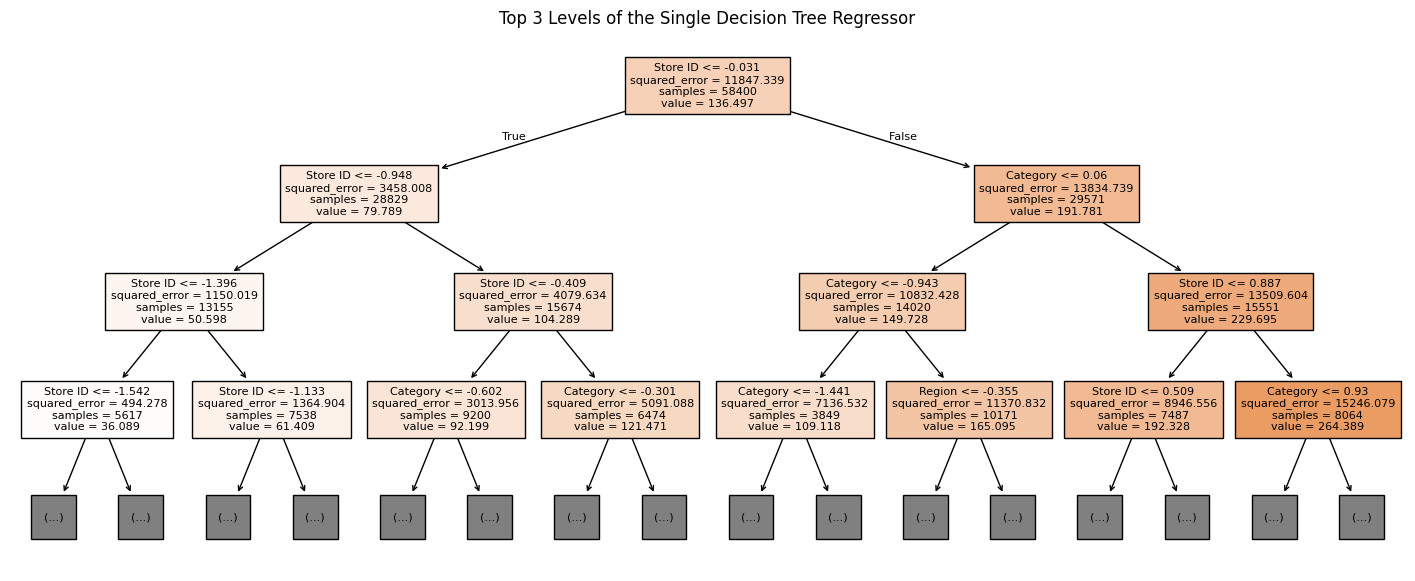

In [312]:
dt_model = models['Decision Tree']
dt_pipeline = create_pipeline(dt_model)
dt_pipeline.fit(X_train, y_train)

plt.figure(figsize=(18, 7))
tree.plot_tree(dt_pipeline.named_steps['regressor'],
               feature_names=X_train.columns,
               filled=True,
               fontsize=8,
               max_depth=3) # Just viewing the top 3 layers... since it's terrible to vizualize all 5.
plt.title("Top 3 Levels of the Single Decision Tree Regressor")
plt.show()

StoreID --> Category --> Region

*The most important features in the Random Forest*

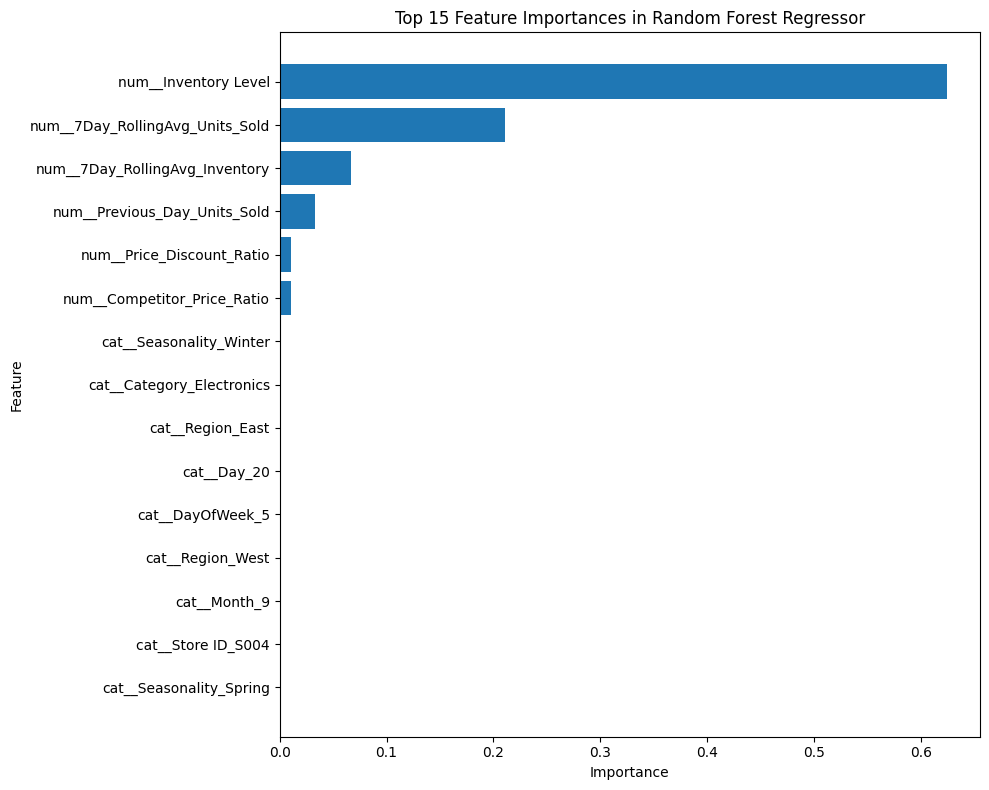

Top 15 Most Important Features:
                             feature  importance
0               num__Inventory Level    0.623894
4    num__7Day_RollingAvg_Units_Sold    0.210894
5     num__7Day_RollingAvg_Inventory    0.066301
3       num__Previous_Day_Units_Sold    0.033476
1          num__Price_Discount_Ratio    0.010390
2        num__Competitor_Price_Ratio    0.010250
49           cat__Seasonality_Winter    0.000785
38         cat__Category_Electronics    0.000751
42                  cat__Region_East    0.000751
84                       cat__Day_20    0.000710
101                 cat__DayOfWeek_5    0.000685
45                  cat__Region_West    0.000676
61                      cat__Month_9    0.000665
9                 cat__Store ID_S004    0.000645
47           cat__Seasonality_Spring    0.000640


In [313]:
importances_rf = pipeline.named_steps['regressor'].feature_importances_
feature_names_processed_rf = pipeline.named_steps['preprocessor'].get_feature_names_out(X_train.columns)

feature_importances_rf = pd.DataFrame({'feature': feature_names_processed_rf, 'importance': importances_rf})
feature_importances_rf = feature_importances_rf.sort_values(by='importance', ascending=False).head(15)


plt.figure(figsize=(10, 8))
plt.barh(feature_importances_rf['feature'], feature_importances_rf['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances in Random Forest Regressor')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


print("Top 15 Most Important Features:")
print(feature_importances_rf)

**Grid Search for Optimal Random Forest Hyperparameters...**

In [320]:
# Grid Search
param_grid_rf = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
}

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)


# Grabing the best parameters and score
best_params_rf = grid_search_rf.best_params_
best_rmse_rf = -grid_search_rf.best_score_ # Converting back to positive RMSE

print("Best Hyperparameters for Random Forest:", best_params_rf)
print("Best RMSE on Cross-Validation:", best_rmse_rf)


# Evaluating the best model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

rmse_rf_tuned_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned_test = r2_score(y_test, y_pred_rf_tuned)

print("Performance of Tuned Random Forest on Test Set:")
print(f"RMSE: {rmse_rf_tuned_test:.4f}")
print(f"R^2: {r2_rf_tuned_test:.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters for Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best RMSE on Cross-Validation: 77.36036103120777
Performance of Tuned Random Forest on Test Set:
RMSE: 77.5584
R^2: 0.4954


The Tuned Random Forest performs slightly better than the previous one.
The R^2 is ~.50 which means it's capturing about 50% of the variance in the data, which isn't terrible!

# Now Let's try this on a Subset of the data, to predict Sales of a Particular Product --> See next Notebook (Model 2)